In [1]:
import tarfile
import os
import csv
import time
import torch
import json
import random


from random import randint
from pathlib import Path
from types import SimpleNamespace
from PIL import Image
import PIL.Image
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from torch import cuda
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
import torchvision.models as models
from matplotlib.ticker import FormatStrFormatter
from google.colab.patches import cv2_imshow
import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
from IPython.display import Image
%matplotlib inline




In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
#extract training data to /tmp/train/
train_tar = tarfile.open('/content/drive/MyDrive/RealTime/cars_train.tar')
train_tar.extractall('/content/drive/MyDrive/RealTime/extract') # specify which folder to extract to
train_tar.close()
#directory looks like /tmp/train/cars_train/

In [ ]:
#extract test data to /tmp/train/
test_tar = tarfile.open('/content/drive/MyDrive/RealTime/cars_test.tgz')
test_tar.extractall('/content/drive/MyDrive/RealTime/extract') # specify which folder to extract to
test_tar.close()
#directory looks like /tmp/train/cars_train/

In [ ]:
#extract labels data to /tmp/train/
label_tar = tarfile.open('/content/drive/MyDrive/RealTime/car_devkit_v2.tgz')
label_tar.extractall('/content/drive/MyDrive/RealTime/extract') # specify which folder to extract to
label_tar.close()
#directory looks like /tmp/train/cars_train/

In [3]:
meta = loadmat('/content/drive/MyDrive/RealTime/extract/devkit/cars_meta.mat')
meta.keys()
type(meta['class_names']),meta['class_names'].shape
[item.flat[0] for item in meta['class_names'][0][0]]
classes = [[row.flat[0] for row in line] for line in meta['class_names'][0]]
classDict = {}
classCount = 1
for c in classes:
    classDict.update({classCount:c[0]})
    classCount = classCount + 1
term = 0
for num, model in classDict.items():
    print('Class #', num,'Model String:', model)
    term = term + 1
    if term == 4:
        break
print('...')

Class # 1 Model String: AM General Hummer SUV 2000
Class # 2 Model String: Acura RL Sedan 2012
Class # 3 Model String: Acura TL Sedan 2012
Class # 4 Model String: Acura TL Type-S 2008
...


In [4]:
#LABELS FOR TRAINING DATA
#contains bbox, class, and filename
labelfile = loadmat('/content/drive/MyDrive/RealTime/extract/devkit/cars_train_annos.mat')
labelfile.keys()
type(labelfile['annotations']),labelfile['annotations'].shape
type(labelfile['annotations'][0][0]),labelfile['annotations'][0][0].shape
labelfile['annotations'][0][0]['bbox_x1'], labelfile['annotations'][0][0]['fname']
[item.flat[0] for item in labelfile['annotations'][0][0]]
"""
The following variable 'trainLabels' contains a list of labels for 
every test image the format of each element is as follows:
### bbox_x1, bbox_y1, bbox_x2, bbox_y2, class, filename
"""
trainLabels = [[row.flat[0] for row in line] for line in labelfile['annotations'][0]]
#Outputting the table for readibility with pandas
columns = ['boundingbox_x1', 'boundingbox_y1', 'boundingbox_x2', 'boundingbox_y2', 'class', 'fname']
view = pd.DataFrame(trainLabels, columns=columns)
view.head()

,boundingbox_x1,boundingbox_y1,boundingbox_x2,boundingbox_y2,class,fname
0,39,116,569,375,14,00001.jpg
1,36,116,868,587,3,00002.jpg
2,85,109,601,381,91,00003.jpg
3,621,393,1484,1096,-122,00004.jpg
4,14,36,133,99,106,00005.jpg


In [5]:
#LABELS FOR TESTING DATA
#Contains bbox and filename
lf = loadmat('/content/drive/MyDrive/RealTime/extract/devkit/cars_test_annos.mat')
lf.keys()
type(lf['annotations']),lf['annotations'].shape
type(lf['annotations'][0][0]),lf['annotations'][0][0].shape
lf['annotations'][0][0]['bbox_x1'], lf['annotations'][0][0]['fname']
[item.flat[0] for item in lf['annotations'][0][0]]
"""
The following variable 'testLabels' contains a list of labels for 
every test image the format of each element is as follows:
### bbox_x1, bbox_y1, bbox_x2, bbox_y2, filename
there is no class name in this set of labels
"""
testLabels = [[row.flat[0] for row in line] for line in lf['annotations'][0]]

#Test labels class and fname
with open('/content/drive/MyDrive/RealTime/extract/devkit/anno_test.csv') as csv_file:
    read = csv.reader(csv_file, delimiter=',')
    testDict = {}
    classCount = 1
    for row in read:
        testDict.update({row[0]:row[5]})
        classCount = classCount + 1
    print(len(testDict), 'processed')

8041 processed


In [6]:
#What labels look like for Training vs Testing after processing
print("Train Labels")
print("...")
for i in range(len(trainLabels) - 4, len(trainLabels)):
    print(trainLabels[i])
print("\nTest Labels")
print("...")
for i in range(len(testLabels) - 4, len(testLabels)):
    print(testLabels[i])

Train Labels
...
[138, 150, 706, 523, 196, '08141.jpg']
[26, 246, 660, 449, 163, '08142.jpg']
[78, 526, 1489, 908, 112, '08143.jpg']
[20, 240, 862, 677, 17, '08144.jpg']

Test Labels
...
[23, 18, 640, 459, '08038.jpg']
[33, 27, 602, 252, '08039.jpg']
[33, 142, 521, 376, '08040.jpg']
[77, 73, 506, 380, '08041.jpg']


In [ ]:
#print(len(trainLabels), "images to process.")
Path("/content/drive/MyDrive/RealTime/extract/processedTrain").mkdir(parents=True, exist_ok=True)
Path("/content/drive/MyDrive/RealTime/extract/processedValidation").mkdir(parents=True, exist_ok=True)
count = 1
for l in trainLabels:
    #print('Processing image', count, 'of', len(trainLabels))
    #bbox
    x1 = l[0]
    y1 = l[1]
    x2 = l[2]
    y2 = l[3]
    class_num = l[4]
    filename = l[5]
    address = "/content/drive/MyDrive/RealTime/extract/cars_train/" + filename
    classAppend = classDict.get(class_num) + '/'
    if count < 7000:
        saveDir = "/content/drive/MyDrive/RealTime/extract/processedTrain/" + classAppend
    else:
        saveDir = "/content/drive/MyDrive/RealTime/extract/processedValidation/" + classAppend
    im = PIL.Image.open(address)
    region = im.crop((x1, y1, x2, y2))
    Path(saveDir).mkdir(parents=True, exist_ok=True)
    saveAddress = saveDir + filename
    region.save(saveAddress)    
    #print('Saved', saveAddress)
    count = count + 1
print("------------------------")
print("Training images preprocessing complete.")

In [ ]:
#print(len(testLabels), "images to process.")
Path("/content/drive/MyDrive/RealTime/extract/processedTest").mkdir(parents=True, exist_ok=True)
Path("/content/drive/MyDrive/RealTime/extract/boundedTest").mkdir(parents=True, exist_ok=True)
count = 1
for l in testLabels:
    #print('Processing image', count, 'of', len(testLabels))
    x1 = l[0]
    y1 = l[1]
    x2 = l[2]
    y2 = l[3]
    filename = l[4]
    c_num = testDict.get(filename)
    classAppend = classDict.get(int(c_num)) + '/'
    address = "/content/drive/MyDrive/RealTime/extract/cars_test/" + filename
    saveDir = "/content/drive/MyDrive/RealTime/extract/processedTest/" + classAppend
    im = PIL.Image.open(address)
    region = im.crop((x1, y1, x2, y2))
    Path(saveDir).mkdir(parents=True, exist_ok=True)
    saveAddress = saveDir + filename
    saveAddress2 = "/content/drive/MyDrive/RealTime/extract/boundedTest/" + filename
    region.save(saveAddress2)    
    #print('Saved', saveAddress2)
    region.save(saveAddress)    
    #print('Saved', saveAddress)
    count = count + 1
print("------------------------")
print("Testing images preprocessing complete.")

------------------------
Testing images preprocessing complete.


Start from here when loading: ALL images have been saved in Drive

In [7]:
def getTrainLoad(directory):
    data = datasets.ImageFolder(directory, 
                                transform = transforms.Compose([transforms.Resize((244,244)),
                                transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    return torch.utils.data.DataLoader(data, batch_size=128, shuffle=True)

def getTestLoad(directory):
    data = datasets.ImageFolder(directory,
                                transform = transforms.Compose([transforms.Resize((244,244)),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    return torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)
trainLoad = getTrainLoad('/content/drive/MyDrive/RealTime/extract/processedTrain')
validLoad = getTestLoad('/content/drive/MyDrive/RealTime/extract/processedValidation')
testLoad = getTestLoad('/content/drive/MyDrive/RealTime/extract/processedTest')

In [8]:
CHECKPOINT_PATH = '/content/drive/MyDrive/RealTime/checkpoint'
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

In [ ]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()
   
free_gpu_cache()       

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=8b947ed74472ee9d2f444b5c1a78f2bd67544b44406e52aa7c62c15d1f59aa16
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
Initial GPU Usage
| ID | GPU | MEM  |
-------------------
|  0 |  0% | 100% |
GPU Usage after emptying the cache
| ID | GPU  | MEM |
-------------------
|  0 | 100% |  1% |


In [ ]:
# Model Creation
model = models.resnet34(pretrained=True)
#num_ftrs = model.classifier.in_features
num_ftrs = model.fc.in_features
#model.classifier = nn.Linear(num_ftrs, 196)
model.fc = nn.Linear(num_ftrs, 196)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
start = time.time()
epochs = 10
iterations = 0
val = 35
model.to(device)
model.train()

def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    model.to(device)
    for i, (images, labels) in enumerate(validloader):
        images, labels = images.to(device), labels.to(device)
        output = model.forward(images)
        valid_loss = valid_loss + criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy = accuracy + equality.type(torch.FloatTensor).mean()
    return valid_loss, accuracy

v_loss_hist = list()
tr_loss_hist = list()
v_acc_hist = list()

for e in range(epochs):
    running_loss = 0
    for i, (inputs, labels) in enumerate(trainLoad):
        iterations += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #validation
        if iterations % val == 0:
            model.eval()
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validLoad, criterion)
            if (e + 1) > len(v_loss_hist):
                v_loss_hist.append(round(valid_loss/len(validLoad),3))
                tr_loss_hist.append(round(running_loss/val,3))
                v_acc_hist.append(round(float(accuracy/len(validLoad)),3))
            print(f"Epoch #  {e+1}, \
            Valid Loss: {round(valid_loss/len(validLoad),5)}, \
            Training Loss: {round(running_loss/val,5)}, \
            Valid Accuracy: {round(float(accuracy/len(validLoad)),5)}")
            model.train()
            lrscheduler.step(accuracy * 100)
end = time.time()
print("Training Complete.")
print("Training time in seconds:", end - start)

In [ ]:
torch.save(model, '/content/drive/MyDrive/RealTime/checkpoint/modelRes.pth')

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/RealTime/checkpoint/modelRes_weights.pth')

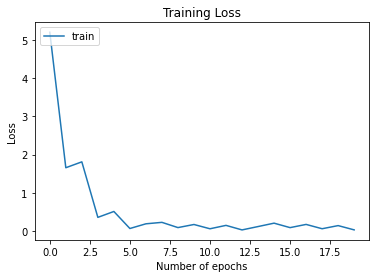

In [ ]:
plt.plot(tr_loss_hist)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()


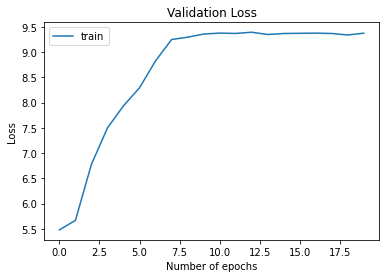

In [ ]:
plt.plot(v_loss_hist)
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()

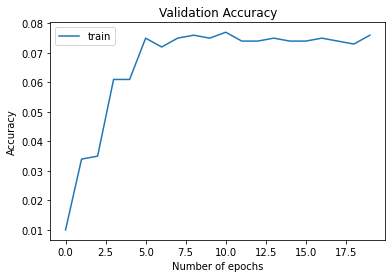

In [ ]:
plt.plot(v_acc_hist)
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
model.to(device)
"""
Tests model accuracy with test images
"""
start = time.time()
total = 0
correct = 0
acc_hist = list()
tot_hist = list()
with torch.no_grad():
    for data in testLoad:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, guess = torch.max(outputs.data, 1) 
        total = total + labels.size(0) #total num of images
        correct = correct + (guess == labels).sum().item() #number correct
        acc_hist.append(correct)
        tot_hist.append(total)
end = time.time()
print("Total images tested in model:", len(testLabels))
print("Total accurate predictions:", correct)
print(f"Accuracy of model w/ full test dataset fed: {round(100 * correct / total,8)}%")
print("Testing time in seconds:", end - start)

Total images tested in model: 8041
Total accurate predictions: 6537
Accuracy of model w/ full test dataset fed: 81.29585872%
Testing time in seconds: 71.58771514892578


In [ ]:
# Model Creation
modelDense = models.densenet161(pretrained=True)
num_ftrs_dense = modelDense.classifier.in_features
#num_ftrs = model.fc.in_features
modelDense.classifier_dense = nn.Linear(num_ftrs_dense, 196)
#model.fc = nn.Linear(num_ftrs, 196)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelDense.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
modelDense.to(device)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
startDense = time.time()
epochs = 15
iterations = 0
val = 35
modelDense.to(device)
modelDense.train()

def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    modelDense.to(device)
    for i, (images, labels) in enumerate(validloader):
        images, labels = images.to(device), labels.to(device)
        output = modelDense.forward(images)
        valid_loss = valid_loss + criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy = accuracy + equality.type(torch.FloatTensor).mean()
    return valid_loss, accuracy

v_loss_hist_dense = list()
tr_loss_hist_dense = list()
v_acc_hist_dense = list()

for e in range(epochs):
    running_loss = 0
    for i, (inputs, labels) in enumerate(trainLoad):
        iterations += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = modelDense.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #validation
        if iterations % val == 0:
            modelDense.eval()
            with torch.no_grad():
                valid_loss, accuracy = validation(modelDense, validLoad, criterion)
            if (e + 1) > len(v_loss_hist_dense):
                v_loss_hist_dense.append(round(valid_loss/len(validLoad),3))
                tr_loss_hist_dense.append(round(running_loss/val,3))
                v_acc_hist_dense.append(round(float(accuracy/len(validLoad)),3))
            print(f"Epoch #  {e+1}, \
            Valid Loss: {round(valid_loss/len(validLoad),5)}, \
            Training Loss: {round(running_loss/val,5)}, \
            Valid Accuracy: {round(float(accuracy/len(validLoad)),5)}")
            modelDense.train()
            lrscheduler.step(accuracy * 100)
endDense = time.time()
print("Training Complete.")
print("Training time in seconds:", endDense - startDense)

Epoch #  1,             Valid Loss: 5.78429,             Training Loss: 5.9374,             Valid Accuracy: 0.01649
Epoch #  2,             Valid Loss: 5.64604,             Training Loss: 1.09424,             Valid Accuracy: 0.04104
Epoch #  2,             Valid Loss: 6.50432,             Training Loss: 2.92588,             Valid Accuracy: 0.06497
Epoch #  3,             Valid Loss: 6.40656,             Training Loss: 0.6393,             Valid Accuracy: 0.06188
Epoch #  4,             Valid Loss: 6.75116,             Training Loss: 0.09664,             Valid Accuracy: 0.07316
Epoch #  4,             Valid Loss: 7.26349,             Training Loss: 0.39702,             Valid Accuracy: 0.07885
Epoch #  5,             Valid Loss: 7.4629,             Training Loss: 0.11396,             Valid Accuracy: 0.07774
Epoch #  6,             Valid Loss: 7.70872,             Training Loss: 0.01201,             Valid Accuracy: 0.07403
Epoch #  6,             Valid Loss: 7.8258,             Training Lo

In [ ]:
torch.save(modelDense, '/content/drive/MyDrive/RealTime/checkpoint/modelDense.pth')

In [ ]:
torch.save(modelDense.state_dict(), '/content/drive/MyDrive/RealTime/checkpoint/modelDense_weights.pth')

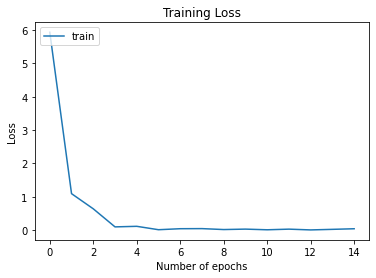

In [ ]:
plt.plot(tr_loss_hist_dense)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()

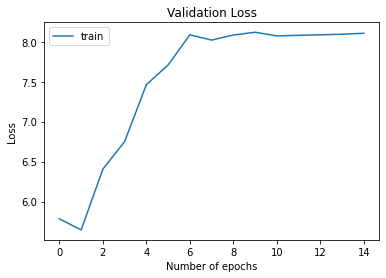

In [ ]:
plt.plot(v_loss_hist_dense)
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()

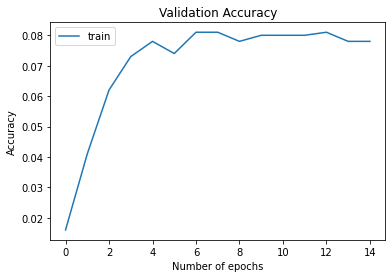

In [ ]:
plt.plot(v_acc_hist_dense)
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
modelDense.to(device)
"""
Tests model accuracy with test images
"""
start = time.time()
total = 0
correct = 0
acc_hist_dense = list()
tot_hist_dense = list()
with torch.no_grad():
    for data in testLoad:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = modelDense(images)
        _, guess = torch.max(outputs.data, 1) 
        total = total + labels.size(0) #total num of images
        correct = correct + (guess == labels).sum().item() #number correct
        acc_hist_dense.append(correct)
        tot_hist_dense.append(total)
end = time.time()
print("Total images tested in model:", len(testLabels))
print("Total accurate predictions:", correct)
print(f"Accuracy of model w/ full test dataset fed: {round(100 * correct / total,8)}%")
print("Testing time in seconds:", end - start)

Total images tested in model: 8041
Total accurate predictions: 6840
Accuracy of model w/ full test dataset fed: 85.06404676%
Testing time in seconds: 3340.3539135456085


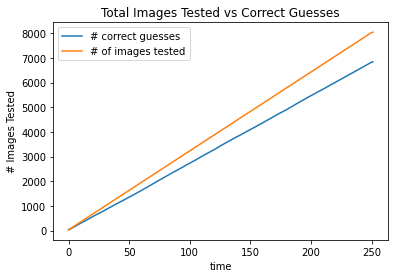

In [ ]:
plt.plot(acc_hist_dense)
plt.plot(tot_hist_dense)
plt.title('Total Images Tested vs Correct Guesses')
plt.ylabel('# Images Tested')
plt.xlabel('time')
plt.legend(['# correct guesses', '# of images tested'], loc='upper left')
plt.show()

In [ ]:
# Model Creation
import torchvision.models as models
modelMobile = models.mobilenet_v2(pretrained=True)
intermediate = modelMobile.classifier[1].in_features
modelMobile.classifier[1] = torch.nn.Linear(in_features=intermediate, out_features=196)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelMobile.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(modelMobile.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=196, bias=True)
)


In [ ]:
startMobile = time.time()
epochs = 20
iterations = 0
val = 35
modelMobile.to(device)
modelMobile.train()

def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    modelMobile.to(device)
    for i, (images, labels) in enumerate(validloader):
        images, labels = images.to(device), labels.to(device)
        output = modelMobile.forward(images)
        valid_loss = valid_loss + criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy = accuracy + equality.type(torch.FloatTensor).mean()
    return valid_loss, accuracy

v_loss_hist_mobile = list()
tr_loss_hist_mobile = list()
v_acc_hist_mobile = list()

for e in range(epochs):
    running_loss = 0
    for i, (inputs, labels) in enumerate(trainLoad):
        iterations += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = modelMobile.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #validation
        if iterations % val == 0:
            modelMobile.eval()
            with torch.no_grad():
                valid_loss, accuracy = validation(modelMobile, validLoad, criterion)
            if (e + 1) > len(v_loss_hist_mobile):
                v_loss_hist_mobile.append(round(valid_loss/len(validLoad),3))
                tr_loss_hist_mobile.append(round(running_loss/val,3))
                v_acc_hist_mobile.append(round(float(accuracy/len(validLoad)),3))
            print(f"Epoch #  {e+1}, \
            Valid Loss: {round(valid_loss/len(validLoad),5)}, \
            Training Loss: {round(running_loss/val,5)}, \
            Valid Accuracy: {round(float(accuracy/len(validLoad)),5)}")
            modelMobile.train()
            lrscheduler.step(accuracy * 100)
endMobile = time.time()
print("Training Complete.")
print("Training time in seconds:", endMobile - startMobile)

Epoch #  1,             Valid Loss: 5.38504,             Training Loss: 5.20777,             Valid Accuracy: 0.00955
Epoch #  2,             Valid Loss: 5.71712,             Training Loss: 1.77216,             Valid Accuracy: 0.01823
Epoch #  2,             Valid Loss: 6.0721,             Training Loss: 5.31726,             Valid Accuracy: 0.02951
Epoch #  3,             Valid Loss: 6.5764,             Training Loss: 2.28317,             Valid Accuracy: 0.04476
Epoch #  4,             Valid Loss: 7.11295,             Training Loss: 0.51067,             Valid Accuracy: 0.04625
Epoch #  4,             Valid Loss: 7.68806,             Training Loss: 2.12671,             Valid Accuracy: 0.05493
Epoch #  5,             Valid Loss: 7.88011,             Training Loss: 0.8382,             Valid Accuracy: 0.05146
Epoch #  6,             Valid Loss: 8.44516,             Training Loss: 0.12512,             Valid Accuracy: 0.06274
Epoch #  6,             Valid Loss: 8.52241,             Training L

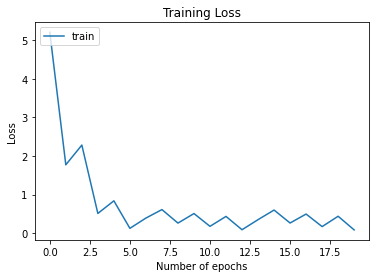

In [ ]:
plt.plot(tr_loss_hist_mobile)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()

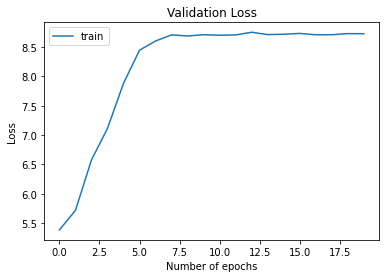

In [ ]:
plt.plot(v_loss_hist_mobile)
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()

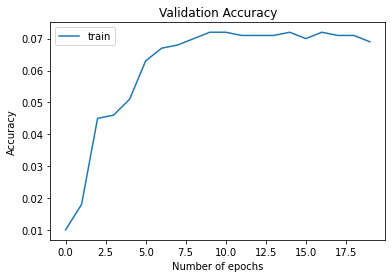

In [ ]:
plt.plot(v_acc_hist_mobile)
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
modelMobile.to(device)
"""
Tests model accuracy with test images
"""
start = time.time()
total = 0
correct = 0
acc_hist_mobile = list()
tot_hist_mobile = list()
with torch.no_grad():
    for data in testLoad:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = modelMobile(images)
        _, guess = torch.max(outputs.data, 1) 
        total = total + labels.size(0) #total num of images
        correct = correct + (guess == labels).sum().item() #number correct
        acc_hist_mobile.append(correct)
        tot_hist_mobile.append(total)
end = time.time()
print("Total images tested in model:", len(testLabels))
print("Total accurate predictions:", correct)
print(f"Accuracy of model w/ full test dataset fed: {round(100 * correct / total,8)}%")
print("Testing time in seconds:", end - start)

Total images tested in model: 8041
Total accurate predictions: 5968
Accuracy of model w/ full test dataset fed: 74.21962442%
Testing time in seconds: 3565.5857338905334


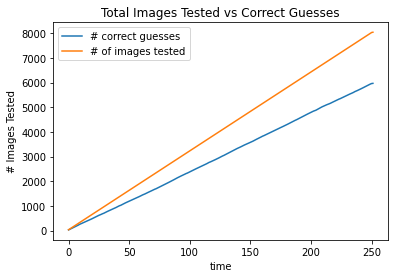

In [ ]:
plt.plot(acc_hist_mobile)
plt.plot(tot_hist_mobile)
plt.title('Total Images Tested vs Correct Guesses')
plt.ylabel('# Images Tested')
plt.xlabel('time')
plt.legend(['# correct guesses', '# of images tested'], loc='upper left')
plt.show()

In [ ]:
torch.save(modelMobile, '/content/drive/MyDrive/RealTime/checkpoint/modelMobile.pth')

In [ ]:
torch.save(modelMobile.state_dict(), '/content/drive/MyDrive/RealTime/checkpoint/modelMobile_weights.pth')

In [ ]:
modelGoogle = models.googlenet(pretrained=True)
num_ftrs = modelGoogle.fc.in_features
modelGoogle.fc = nn.Linear(num_ftrs, 196)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelGoogle.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
modelGoogle.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
startGoogle = time.time()
epochs = 20
iterations = 0
val = 35
modelGoogle.to(device)
modelGoogle.train()

def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    modelGoogle.to(device)
    for i, (images, labels) in enumerate(validloader):
        images, labels = images.to(device), labels.to(device)
        output = modelGoogle.forward(images)
        valid_loss = valid_loss + criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy = accuracy + equality.type(torch.FloatTensor).mean()
    return valid_loss, accuracy

v_loss_hist_google = list()
tr_loss_hist_google = list()
v_acc_hist_google = list()

for e in range(epochs):
    running_loss = 0
    for i, (inputs, labels) in enumerate(trainLoad):
        iterations += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = modelGoogle.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #validation
        if iterations % val == 0:
            modelGoogle.eval()
            with torch.no_grad():
                valid_loss, accuracy = validation(modelGoogle, validLoad, criterion)
            if (e + 1) > len(v_loss_hist_google):
                v_loss_hist_google.append(round(valid_loss/len(validLoad),3))
                tr_loss_hist_google.append(round(running_loss/val,3))
                v_acc_hist_google.append(round(float(accuracy/len(validLoad)),3))
            print(f"Epoch #  {e+1}, \
            Valid Loss: {round(valid_loss/len(validLoad),5)}, \
            Training Loss: {round(running_loss/val,5)}, \
            Valid Accuracy: {round(float(accuracy/len(validLoad)),5)}")
            modelGoogle.train()
            lrscheduler.step(accuracy * 100)
endGoogle = time.time()
print("Training Complete.")
print("Training time in seconds:", endGoogle - startGoogle)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch #  1,             Valid Loss: 5.27987,             Training Loss: 5.29185,             Valid Accuracy: 0.00521
Epoch #  2,             Valid Loss: 5.27193,             Training Loss: 2.16968,             Valid Accuracy: 0.00955
Epoch #  2,             Valid Loss: 5.27594,             Training Loss: 7.0818,             Valid Accuracy: 0.01326
Epoch #  3,             Valid Loss: 5.35064,             Training Loss: 3.86282,             Valid Accuracy: 0.01587
Epoch #  4,             Valid Loss: 5.49195,             Training Loss: 1.12635,             Valid Accuracy: 0.0176
Epoch #  4,             Valid Loss: 5.63204,             Training Loss: 4.90986,             Valid Accuracy: 0.02778
Epoch #  5,             Valid Loss: 5.83915,             Training Loss: 2.36833,             Valid Accuracy: 0.03733
Epoch #  6,             Valid Loss: 6.09204,             Training Loss: 0.39307,             Valid Accuracy: 0.03868
Epoch #  6,             Valid Loss: 6.43431,             Training 

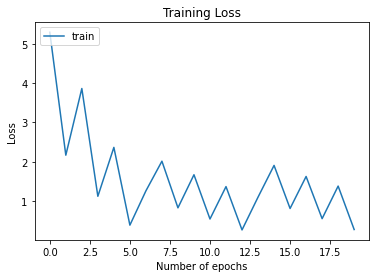

In [ ]:
plt.plot(tr_loss_hist_google)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()

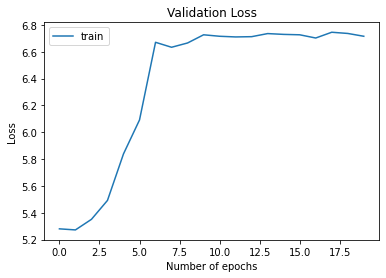

In [ ]:
plt.plot(v_loss_hist_google)
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()

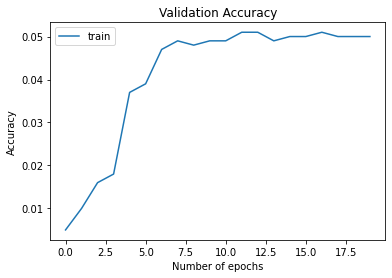

In [ ]:
plt.plot(v_acc_hist_google)
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
torch.save(modelGoogle, '/content/drive/MyDrive/RealTime/checkpoint/modelGoogle.pth')

In [ ]:
torch.save(modelGoogle.state_dict(), '/content/drive/MyDrive/RealTime/checkpoint/modelGoogle_weights.pth')

In [ ]:
modelGoogle.to(device)
"""
Tests model accuracy with test images
"""
start = time.time()
total = 0
correct = 0
acc_hist_google = list()
tot_hist_google = list()
with torch.no_grad():
    for data in testLoad:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = modelGoogle(images)
        _, guess = torch.max(outputs.data, 1) 
        total = total + labels.size(0) #total num of images
        correct = correct + (guess == labels).sum().item() #number correct
        acc_hist_google.append(correct)
        tot_hist_google.append(total)
end = time.time()
print("Total images tested in model:", len(testLabels))
print("Total accurate predictions:", correct)
print(f"Accuracy of model w/ full test dataset fed: {round(100 * correct / total,8)}%")
print("Testing time in seconds:", end - start)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Total images tested in model: 8041
Total accurate predictions: 4150
Accuracy of model w/ full test dataset fed: 51.61049621%
Testing time in seconds: 63.062340259552


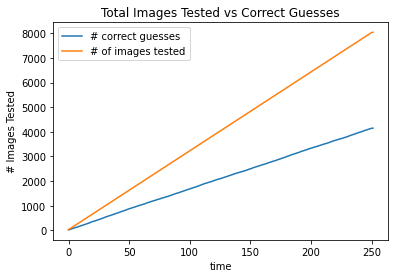

In [ ]:
plt.plot(acc_hist_google)
plt.plot(tot_hist_google)
plt.title('Total Images Tested vs Correct Guesses')
plt.ylabel('# Images Tested')
plt.xlabel('time')
plt.legend(['# correct guesses', '# of images tested'], loc='upper left')
plt.show()

In [11]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, idx = find_classes("/content/drive/MyDrive/RealTime/extract/processedTest")

def predict(image, model, topk=5):
    #open image and change to np form//cpu consideration
    pil_in = PIL.Image.open(image)
    transform = transforms.Compose([transforms.Resize((244,244)),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])])
    pilTrans = transform(pil_in)
    img = np.array(pilTrans)
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor) #np to tensor
    dimen = img_tensor.unsqueeze_(0)
    model.eval()
    with torch.no_grad():
        output = model.forward(dimen)
    probs_top = output.topk(topk)[0]
    top_prediction = output.topk(topk)[1]
    p = np.array(top_prediction)[0]
    o_guesses = np.array(top_prediction)[0]
    return p, o_guesses

In [ ]:
# Load ResNet - Dataset which was tested by James Wang
model = models.resnet34(pretrained=True)
#num_ftrs = model.classifier.in_features
num_ftrs = model.fc.in_features
#model.classifier = nn.Linear(num_ftrs, 196)
model.fc = nn.Linear(num_ftrs, 196)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('/content/drive/MyDrive/RealTime/checkpoint/modelRes_weights.pth', map_location ='cpu'))
model.eval()

In [ ]:
#Load DenseNet161 Model 
modelDense = models.densenet161(pretrained=True)
num_ftrs_dense = modelDense.classifier.in_features
#num_ftrs = model.fc.in_features
modelDense.classifier_dense = nn.Linear(num_ftrs_dense, 196)
#model.fc = nn.Linear(num_ftrs, 196)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelDense.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
modelDense.load_state_dict(torch.load('/content/drive/MyDrive/RealTime/checkpoint/modelDense_weights.pth', map_location ='cpu'))
modelDense.eval()

In [ ]:
#Load MobileNetV2 Model
modelMobile = models.mobilenet_v2(pretrained=True)
intermediate = modelMobile.classifier[1].in_features
modelMobile.classifier[1] = torch.nn.Linear(in_features=intermediate, out_features=196)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelMobile.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
modelMobile.load_state_dict(torch.load('/content/drive/MyDrive/RealTime/checkpoint/modelMobile_weights.pth', map_location ='cpu'))
modelMobile.eval()

In [ ]:
#Load GoogleNet Model
modelGoogle = models.googlenet(pretrained=True)
num_ftrs = modelGoogle.fc.in_features
modelGoogle.fc = nn.Linear(num_ftrs, 196)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelGoogle.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
modelGoogle.load_state_dict(torch.load('/content/drive/MyDrive/RealTime/checkpoint/modelGoogle_weights.pth', map_location ='cpu'))
modelGoogle.eval()

Randomly chosen file to classify: /content/drive/MyDrive/RealTime/extract/boundedTest/00913.jpg
Seconds elapsed for prediction: 0.5319845676422119
*******************************
FIRST GUESS:  Suzuki SX4 Sedan 2012
*******************************
Might also be: Acura RL Sedan 2012
Might also be: Acura TSX Sedan 2012
Might also be: Suzuki Aerio Sedan 2007
Might also be: Chevrolet Impala Sedan 2007 



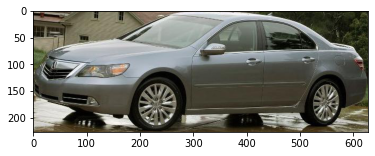

In [12]:
#Determine with Resnet
#random_test_image = str(str(randint(1, len(testLabels))).zfill(5)) + '.jpg'
image_to_classify = "/content/drive/MyDrive/RealTime/extract/boundedTest/" + "00913.jpg"
device = ('cpu')
start = time.time()
tp, ps = predict(image_to_classify, model, topk=5)
print("Randomly chosen file to classify:",image_to_classify)
end = time.time()
print("Seconds elapsed for prediction:", end - start)
print("*******************************")
print("FIRST GUESS: ",classes[ps[0]])
print("*******************************")
print("Might also be:", classes[ps[1]])
print("Might also be:", classes[ps[2]])
print("Might also be:", classes[ps[3]])
print("Might also be:", classes[ps[4]], "\n")
gimg = mpimg.imread(image_to_classify)
imshow(gimg)

Randomly chosen file to classify: /content/drive/MyDrive/RealTime/extract/boundedTest/00913.jpg
Seconds elapsed for prediction: 0.27501988410949707
*******************************
FIRST GUESS:  Acura RL Sedan 2012
*******************************
Might also be: Chrysler 300 SRT-8 2010
Might also be: Suzuki SX4 Sedan 2012
Might also be: Honda Accord Sedan 2012
Might also be: Lincoln Town Car Sedan 2011 



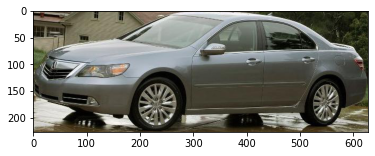

In [ ]:
#Determine with DenseNet
#random_test_image = str(str(randint(1, len(testLabels))).zfill(5)) + '.jpg'
image_to_classify = "/content/drive/MyDrive/RealTime/extract/boundedTest/" + "00913.jpg"
device = ('cpu')
start = time.time()
tp, ps = predict(image_to_classify, modelDense, topk=5)
print("Randomly chosen file to classify:",image_to_classify)
end = time.time()
print("Seconds elapsed for prediction:", end - start)
print("*******************************")
print("FIRST GUESS: ",classes[ps[0]])
print("*******************************")
print("Might also be:", classes[ps[1]])
print("Might also be:", classes[ps[2]])
print("Might also be:", classes[ps[3]])
print("Might also be:", classes[ps[4]], "\n")
gimg = mpimg.imread(image_to_classify)
imshow(gimg)

Randomly chosen file to classify: /content/drive/MyDrive/RealTime/extract/boundedTest/00913.jpg
Seconds elapsed for prediction: 0.05589699745178223
*******************************
FIRST GUESS:  Acura RL Sedan 2012
*******************************
Might also be: Suzuki SX4 Sedan 2012
Might also be: Suzuki Aerio Sedan 2007
Might also be: Mitsubishi Lancer Sedan 2012
Might also be: Hyundai Veracruz SUV 2012 



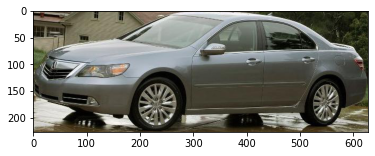

In [ ]:
#Determine with MobileNet
#random_test_image = str(str(randint(1, len(testLabels))).zfill(5)) + '.jpg'
image_to_classify = "/content/drive/MyDrive/RealTime/extract/boundedTest/" + "00913.jpg"
device = ('cpu')
start = time.time()
tp, ps = predict(image_to_classify, modelMobile, topk=5)
print("Randomly chosen file to classify:",image_to_classify)
end = time.time()
print("Seconds elapsed for prediction:", end - start)
print("*******************************")
print("FIRST GUESS: ",classes[ps[0]])
print("*******************************")
print("Might also be:", classes[ps[1]])
print("Might also be:", classes[ps[2]])
print("Might also be:", classes[ps[3]])
print("Might also be:", classes[ps[4]], "\n")
gimg = mpimg.imread(image_to_classify)
imshow(gimg)

Randomly chosen file to classify: /content/drive/MyDrive/RealTime/extract/boundedTest/00913.jpg
Seconds elapsed for prediction: 0.11672806739807129
*******************************
FIRST GUESS:  Chevrolet Malibu Hybrid Sedan 2010
*******************************
Might also be: Mitsubishi Lancer Sedan 2012
Might also be: BMW 3 Series Wagon 2012
Might also be: Suzuki Kizashi Sedan 2012
Might also be: BMW ActiveHybrid 5 Sedan 2012 



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


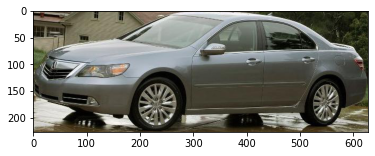

In [ ]:
#Determine with GoogleNet
#random_test_image = str(str(randint(1, len(testLabels))).zfill(5)) + '.jpg'
image_to_classify = "/content/drive/MyDrive/RealTime/extract/boundedTest/" + "00913.jpg"
device = ('cpu')
start = time.time()
tp, ps = predict(image_to_classify, modelGoogle, topk=5)
print("Randomly chosen file to classify:",image_to_classify)
end = time.time()
print("Seconds elapsed for prediction:", end - start)
print("*******************************")
print("FIRST GUESS: ",classes[ps[0]])
print("*******************************")
print("Might also be:", classes[ps[1]])
print("Might also be:", classes[ps[2]])
print("Might also be:", classes[ps[3]])
print("Might also be:", classes[ps[4]], "\n")
gimg = mpimg.imread(image_to_classify)
imshow(gimg)